In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant("cuda_ad_rgb")

import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from mitsuba.python.ad.integrators.common import ADIntegrator, mis_weight
from tqdm import tqdm
import math

import tinycudann as tcnn 

torch.autograd.set_detect_anomaly(True)


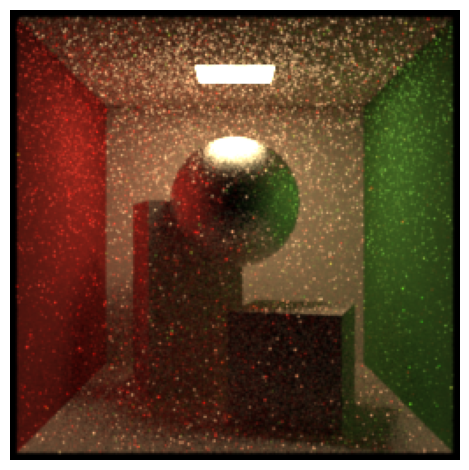

In [2]:
# default cornell box
scene_dict = mi.cornell_box()
scene_dict['sphere'] = {
    'type': 'sphere',
    'radius': 0.4,
    'center': [0, 0.2, 0], 
    'bsdf': {
        'type': 'roughconductor',
        'alpha': 0.3  
    }
}
scene = mi.load_dict(scene_dict)

original_image = mi.render(scene, spp=16)

fig, ax = plt.subplots()
fig.patch.set_visible(False)  # Hide the figure's background
ax.axis('off')  # Remove the axes from the image
fig.tight_layout()  # Remove any extra white spaces around the image
ax.imshow(np.clip(original_image ** (1.0 / 2.2), 0, 1))


In [3]:
"""
In relation to Hierachical Light Sampling paper by AMD, light is going to be represented as pair of Gaussian + vMF
    * Isotropic Gaussian, approximates the light positions distirbution
        μ - mean (centre of Gaussian)
        σ2 - variance (spread of distribution)
    * vMF, approximates directional distirbution of radiant intensity (Normalized Gaussian)
        κ - sharpness
        ν - axis
        α - amplitude

So final struct that we have:
[
    vec3  mean
    float variance
    float sharpness
    vec3  axis
    vec3  amplitude
]

Going to call Gaussian vMF pair - Virtual Anisotropic Point Light - VAPL

"""


class vapl_grid(torch.nn.Module):
    def __init__(self, bb_min, bb_max, num_gaussian_in_mixture, num_param_per_gaussian, num_param_per_vmf):
        super().__init__()

        self.bb_min = bb_min
        self.bb_max = bb_max

        # tiny-cuda-nn config for hash grid
        config = {
            "encoding": {
                "otype": "HashGrid",
                "base_resolution": 16,
                "n_levels": num_gaussian_in_mixture,
                "n_features_per_level": num_param_per_gaussian,
                "log2_hashmap_size": 22,
            },
        }
        n_input_dims = 3
        self.gaussian_grid = tcnn.Encoding(n_input_dims, config["encoding"])

        config["encoding"]["n_features_per_level"] = num_param_per_vmf
        self.vmf_grid = tcnn.Encoding(n_input_dims, config["encoding"])

        self.sg_optimizer = torch.optim.Adam(self.gaussian_grid.parameters(), lr=0.01)
        self.vmf_optimizer = torch.optim.Adam(self.vmf_grid.parameters(), lr = 0.01)

    def forward(self, si):
        with dr.suspend_grad():
            # get the position of ray-scene intersection in scene bb
            X = ((si.p - self.bb_min) / (self.bb_max - self.bb_min)).torch()
            gaussians : torch.Tensor = self.gaussian_grid(X.T)
            gaussians.requires_grad_()
            vmf : torch.Tensor = self.vmf_grid(X.T)
            vmf.requires_grad_()

        eps = 1e-2
        
        mean = gaussians[:, :3]
        bb_min = torch.tensor(self.bb_min, device=mean.device)
        bb_max = torch.tensor(self.bb_max, device=mean.device)
        
        mean = mean / eps * 0.5 + 0.5
        mean = mean * (bb_max - bb_min).unsqueeze(0) + bb_min.unsqueeze(0)
        
        variance = gaussians[:, 3]
        variance = torch.relu(variance)

        sharpness = vmf[:, 0]
        sharpness = torch.exp(sharpness)

        axis = vmf[:, 1:4]
        norm = torch.norm(axis, dim=1, keepdim=True)  
        axis = torch.div(axis, norm + 1e-6)

        amplitude = vmf[:, 4:7]
        amplitude = torch.relu(vmf[:, 4:7])

        variance = variance.unsqueeze(1)
        sharpness = sharpness.unsqueeze(1)
    
        gaussians = torch.cat([mean, variance], dim = 1)
        vmf = torch.cat([sharpness, axis, amplitude], dim = 1)

        return gaussians, vmf    

def get_camera_first_bounce(scene):
    cam_origin = mi.Point3f(0, 1, 3)
    cam_dir = dr.normalize(mi.Vector3f(0, -0.5, -1))
    cam_width = 2.0
    cam_height = 2.0
    image_res = [4, 4]

    x, y = dr.meshgrid(
        dr.linspace(mi.Float, -cam_width / 2, cam_width / 2, image_res[0]),
        dr.linspace(mi.Float, -cam_height / 2, cam_height / 2, image_res[1]),
    )
    ray_origin_local = mi.Vector3f(x, y, 0)
    ray_origin = mi.Frame3f(cam_dir).to_world(ray_origin_local) + cam_origin
    ray = mi.Ray3f(o=ray_origin, d=cam_dir)
    si = scene.ray_intersect(ray)

    return si, image_res
    
# Just mitsuba testing
si, res = get_camera_first_bounce(scene)
bsdf : mi.cuda_ad_rgb.BSDFPtr = si.bsdf()
reflectance = bsdf.eval_diffuse_reflectance(si)


In [4]:
def sg_product(axis1: torch.Tensor, sharpness1: torch.Tensor, axis2: torch.Tensor, sharpness2: torch.Tensor):
    axis = axis1 * sharpness1 + axis2 * sharpness2 
    sharpness = torch.norm(axis, dim=1, keepdim=True)

    d = axis1 - axis2
    len2 = torch.sum(d * d, dim=1, keepdim=True) 

    denom = torch.maximum(sharpness + sharpness1 + sharpness2, torch.tensor(torch.finfo(torch.float32).max, device=sharpness.device))
    log_amplitude = -sharpness1 * sharpness2 * len2 / denom

    axis = axis / torch.maximum(sharpness, torch.tensor(torch.finfo(torch.float32).eps, device=sharpness.device)) 

    return axis, sharpness, log_amplitude

# [Tokuyoshi et al. 2024 "Hierarchical Light Sampling with Accurate Spherical Gaussian Lighting (Supplementary Document)" Listing. 5]
def upper_sg_clamp_cosine_integral_over_two_pi(sharpness: torch.Tensor):
    small_sharpness = sharpness <= 0.5
    sharpness_safe = torch.clamp(sharpness, min=1e-6, max=50)  # Ограничение

    # Taylor-series approximation for numerical stability.
    taylor_series = (
        (-1.0 / 362880.0) * sharpness_safe +
        (1.0 / 40320.0)
    )
    taylor_series = taylor_series * sharpness_safe - (1.0 / 5040.0)
    taylor_series = taylor_series * sharpness_safe + (1.0 / 720.0)
    taylor_series = taylor_series * sharpness_safe - (1.0 / 120.0)
    taylor_series = taylor_series * sharpness_safe + (1.0 / 24.0)
    taylor_series = taylor_series * sharpness_safe - (1.0 / 6.0)
    taylor_series = taylor_series * sharpness_safe + 0.5

    integral = torch.where(
        small_sharpness, 
        taylor_series, 
        (torch.expm1(-sharpness_safe) + sharpness_safe) / (sharpness_safe * sharpness_safe)
    )
    
    return torch.nan_to_num(integral, nan=0.0, posinf=1e6, neginf=-1e6)

# [Tokuyoshi et al. 2024 "Hierarchical Light Sampling with Accurate Spherical Gaussian Lighting (Supplementary Document)" Listing. 6]
def lower_sg_clamp_cosine_integral_over_two_pi(sharpness: torch.Tensor):
    sharpness_safe = torch.clamp(sharpness, min=1e-6, max=50)  # Ограничение
    e = torch.exp(-sharpness_safe)
    small_sharpness = sharpness_safe <= 0.5

    # Taylor-series approximation for numerical stability.
    taylor_series = (1.0 / 403200.0) * sharpness_safe - (1.0 / 45360.0)
    taylor_series = taylor_series * sharpness_safe + (1.0 / 5760.0)
    taylor_series = taylor_series * sharpness_safe - (1.0 / 840.0)
    taylor_series = taylor_series * sharpness_safe + (1.0 / 144.0)
    taylor_series = taylor_series * sharpness_safe - (1.0 / 30.0)
    taylor_series = taylor_series * sharpness_safe + (1.0 / 8.0)
    taylor_series = taylor_series * sharpness_safe - (1.0 / 3.0)
    taylor_series = taylor_series * sharpness_safe + 0.5
    taylor_series = e * taylor_series  # Перенос умножения на `e` в конец

    integral = torch.where(
        small_sharpness,
        taylor_series,
        e * (-torch.expm1(-sharpness_safe) - sharpness_safe * e) / (sharpness_safe * sharpness_safe)
    )

    return torch.nan_to_num(integral, nan=0.0, posinf=1e6, neginf=-1e6)

# Approximate product integral of an SG and clamped cosine / pi.
# [Tokuyoshi et al. 2024 "Hierarchical Light Sampling with Accurate Spherical Gaussian Lighting (Supplementary Document)" Listing. 7]
def sg_clamp_cosine_product_integral_over_pi(cosine: torch.Tensor, sharpness: torch.Tensor):
    A = 2.7360831611272558028247203765204
    B = 17.02129778174187535455530451145
    C = 4.0100826728510421403939290030394
    D = 15.219156263147210594866010069381
    E = 76.087896272360737270901154261082

    sharpness_safe = torch.clamp(sharpness, min=1e-6, max=50)  # Ограничение sharpness
    sqrt_term = 0.5 * ((sharpness_safe * A) * sharpness_safe + B) / (((sharpness_safe + C) * sharpness_safe + D) * sharpness_safe + E)
    sqrt_safe = torch.sqrt(torch.clamp(sqrt_term, min=1e-6)) 
    t = sharpness_safe * sqrt_safe
    tz = t * cosine

    INV_SQRTPI = 0.56418958354775628694807945156077  
    CLAMPING_THRESHOLD = torch.tensor(0.5 * torch.finfo(torch.float32).eps, dtype=torch.float32, device=cosine.device)

    erfc_neg_tz = torch.erfc(-tz)
    erfc_t = torch.erfc(t)
    exp_neg_tz2 = torch.exp(-torch.clamp(tz * tz, max=50))  # Ограничиваем экспоненту
    exp_safe = torch.expm1(torch.clamp(t * t * (cosine * cosine - 1.0), min=-50, max=50))  # Ограничиваем expm1

    exp_term = torch.where(t.abs() > 1e-6, exp_safe / t, torch.zeros_like(t))

    lerp_factor = torch.clamp(
        torch.max(
            0.5 * (cosine * erfc_neg_tz + erfc_t) - 0.5 * INV_SQRTPI * exp_neg_tz2 * exp_term,
            CLAMPING_THRESHOLD
        ),
        0.0, 1.0
    )

    lower_integral = lower_sg_clamp_cosine_integral_over_two_pi(sharpness_safe)
    upper_integral = upper_sg_clamp_cosine_integral_over_two_pi(sharpness_safe)

    return 2.0 * torch.lerp(lower_integral, upper_integral, lerp_factor)

def sggx(m: torch.Tensor, roughness_mat: torch.Tensor) -> torch.Tensor:
    det = torch.det(roughness_mat).clamp(min=1e-7)  
    
    roughness_mat_adj = torch.stack([
        torch.stack([roughness_mat[..., 1, 1], -roughness_mat[..., 0, 1]], dim=-1),
        torch.stack([-roughness_mat[..., 1, 0], roughness_mat[..., 0, 0]], dim=-1)
    ], dim=-2)

    m_xy = m[..., :2].unsqueeze(-2) 
    length2 = (m_xy @ roughness_mat_adj @ m_xy.transpose(-2, -1)).squeeze(-1).squeeze(-1) / det + m[..., 2] ** 2
    
    length2 = length2.clamp(min=1e-4)  
    sqrt_det = torch.sqrt(det).clamp(min=1e-4)

    denom = sqrt_det * length2 ** 2  
    return 1.0 / (math.pi * denom)






# Approximate the reflection lobe with an SG lobe for microfacet BRDFs.
# [Wang et al. 2009 "All-Frequency Rendering with Dynamic, Spatially-Varying Reflectance"]
def sgg_reflection_pdf(wi: torch.Tensor, m: torch.Tensor, roughness_mat: torch.Tensor) -> torch.Tensor:
    xy = wi[:2]
    rough_wi = torch.matmul(roughness_mat, xy)
    denom = torch.sqrt(torch.sum(xy * rough_wi) + wi[2] * wi[2])
    sggx_tensor = sggx(m, roughness_mat)
    return sggx_tensor.unsqueeze(-1) / (4.0 * denom)

# Approximate hemispherical integral for a vMF distribution (i.e. normalized SG).
# The parameter "cosine" is the cosine of the angle between the SG axis and the pole axis of the hemisphere.
# [Tokuyoshi et al. 2024 "Hierarchical Light Sampling with Accurate Spherical Gaussian Lighting (Supplementary Document)" Listing. 4]
def vmf_hemispherical_integral(cosine : torch.Tensor, sharpness : torch.Tensor):
    cosine = cosine.unsqueeze(-1)
    # interpolation factor [Tokuyoshi 2022].
    A = 0.6517328826907056171791055021459
    B = 1.3418280033141287699294252888649
    C = 7.2216687798956709087860872386955
    steepness = sharpness * torch.sqrt((0.5 * sharpness + A) / ((sharpness + B) * sharpness + C))
    lerp_factor = torch.clamp(0.5 + 0.5 * (torch.erf(steepness * torch.clamp(cosine, -1.0, 1.0)) / torch.erf(steepness)), 0, 1)

    # Interpolation between upper and lower hemispherical integrals
    e = torch.exp(-sharpness)
    one_tensor = torch.tensor(1.0, device=e.device, dtype=e.dtype) 
    return torch.lerp(e, one_tensor, lerp_factor) / (e + 1.0)

def luminance(color: torch.Tensor):
    weights = torch.tensor([0.2126, 0.7152, 0.0722], device=color.device)
    return torch.sum(color * weights, dim=1) 

def compute_jacobian(wi_tensor: torch.Tensor):
    vlen = torch.linalg.norm(wi_tensor[:, :2], dim=1, keepdim=True)  

    v = torch.where(
        vlen == 0,
        torch.tensor([[1.0, 0.0]], device=wi_tensor.device, dtype=wi_tensor.dtype).expand(wi_tensor.shape[0], -1),
        wi_tensor[:, :2] / vlen
    ) 

    rot_mat = torch.stack([
        torch.stack([v[:, 0], -v[:, 1]], dim=-1),  
        torch.stack([v[:, 1],  v[:, 0]], dim=-1)   
    ], dim=1)  

    scale_mat = torch.stack([
        torch.full((wi_tensor.shape[0], 2), 0.5, device=wi_tensor.device, dtype=wi_tensor.dtype),
        torch.stack([torch.zeros_like(wi_tensor[:, 2]), 0.5 / wi_tensor[:, 2]], dim=-1)
    ], dim=1)  
    jacobian_mat = torch.matmul(rot_mat, scale_mat)
    jj_mat = torch.matmul(jacobian_mat, jacobian_mat.transpose(1, 2))

    return jj_mat



def isotropic_ndf_filtering(si: mi.SurfaceInteraction3f):
    SIGMA2 = 0.15915494  # Variance of pixel filter kernel (1/(2pi))
    KAPPA = 0.18 

    dndu = torch.from_numpy(si.dn_du.numpy()).to("cuda").T
    dndv = torch.from_numpy(si.dn_dv.numpy()).to("cuda").T
    mask = si.is_valid()
    roughness = torch.tensor(si.bsdf().eval_attribute_1("roughness", si, mask), dtype=torch.float32).unsqueeze(-1)  

    # Eq. 14 
    kernel_roughness2 = SIGMA2 * (torch.sum(dndu * dndu, dim=-1) + torch.sum(dndv * dndv, dim=-1))  
    kernel_roughness2 = kernel_roughness2.unsqueeze(-1)
    clamped_kernel_roughness2 = torch.clamp(kernel_roughness2, max=KAPPA)
    filtered_roughness2 = torch.clamp(roughness**2 + clamped_kernel_roughness2, min=0.0, max=1.0) 

    return torch.sqrt(filtered_roughness2) 

def compute_filtered_roughness_mat(filtered_proj_roughness_mat, tr, det):
    FLT_MAX = torch.finfo(torch.float32).max 

    denom = 1.0 + tr + det
    is_finite = torch.isfinite(denom)

    det_mat = torch.zeros_like(filtered_proj_roughness_mat)
    det_mat[:, 0, 0] = det
    det_mat[:, 1, 1] = det

    mat1 = torch.clamp(filtered_proj_roughness_mat + det_mat, max=FLT_MAX) / denom.unsqueeze(-1).unsqueeze(-1)

    mat2 = torch.zeros_like(filtered_proj_roughness_mat)
    mat2[:, 0, 0] = torch.clamp(filtered_proj_roughness_mat[:, 0, 0], max=FLT_MAX) / torch.clamp(filtered_proj_roughness_mat[:, 0, 0] + 1.0, max=FLT_MAX)
    mat2[:, 1, 1] = torch.clamp(filtered_proj_roughness_mat[:, 1, 1], max=FLT_MAX) / torch.clamp(filtered_proj_roughness_mat[:, 1, 1] + 1.0, max=FLT_MAX)

    return torch.where(is_finite.unsqueeze(-1).unsqueeze(-1), mat1, mat2)


# (exp(x) - 1)/x with cancellation of rounding errors.
# [Nicholas J. Higham "Accuracy and Stability of Numerical Algorithms", Section 1.14.1, p. 19]
def expm1_over_x(x: torch.Tensor) -> torch.Tensor:
    y = torch.expm1(x) 
    result = y / x
    result = torch.where(torch.abs(x) < 1.0, y / x, result)
    return result
          
def sg_integral(sharpness):
    return 4.0 * torch.pi * expm1_over_x(-2.0 * sharpness)

def orthonormal_basis(axis: torch.Tensor):
    s = torch.where(axis[:, 2] >= 0.0, 1.0, -1.0)  
    c = -1.0 / (s + axis[:, 2])  
    b = axis[:, 0] * axis[:, 1] * c  
    b1 = torch.stack([
        1.0 + s * axis[:, 0] * axis[:, 0] * c,
        s * b,
        -s * axis[:, 0]
    ], dim=1)  
    b2 = torch.stack([
        b,
        s + axis[:, 1] * axis[:, 1] * c,
        -axis[:, 1]
    ], dim=1)  

    return torch.stack([b1, b2, axis], dim=1) 

def sample_vmf(axis: torch.Tensor, sharpness: torch.Tensor):
    rand = torch.rand((axis.shape[0], 2), dtype=axis.dtype, device=axis.device) 
    phi = 2.0 * math.pi * rand[:, 0] 
    THRESHOLD = torch.finfo(torch.float32).eps / 4.0

    mask = sharpness.squeeze(-1) > THRESHOLD 
    r = torch.empty_like(sharpness.squeeze(-1))

    r[mask] = torch.log1p(rand[mask, 1] * torch.expm1(-2.0 * sharpness[mask, 0])) / sharpness[mask, 0]
    r[~mask] = -2.0 * rand[~mask, 1]

    cos_theta = 1.0 + r 
    sin_theta = torch.sqrt(-r * r - 2.0 * r) 

    dir = torch.stack([
        torch.cos(phi) * sin_theta,  
        torch.sin(phi) * sin_theta,  
        cos_theta                    
    ], dim=1) 

    frame = orthonormal_basis(axis)

    return torch.einsum('nij,nj->ni', frame, dir) 

def batched_matmul(A, B, batch_size=1024):
    N = A.shape[0] 
    result = []

    for i in range(0, N, batch_size):
        batch_A = A[i : i + batch_size] 
        batch_B = B[i : i + batch_size] 
        
        batch_result = torch.bmm(batch_A, batch_B)
        result.append(batch_result)

    return torch.cat(result, dim=0)


In [ ]:
# BSDF Approximations: Diffuse as CosineLobeSG, Specular as AnisotropicSG
class cosine_lobe_sg:
    def __init__(self, direction : torch.Tensor):
        self.axis = direction
        self.sharpness = torch.full((direction.shape[0], 1), 2.123, device=direction.device, dtype=direction.dtype)
        self.amplitude = torch.full((direction.shape[0], 1), 1.17, device=direction.device, dtype=direction.dtype)

def asg_reflection_lobe(dir: torch.Tensor, normal: torch.Tensor, roughness2: torch.Tensor):
    # Compute ASG sharpness for the NDF
    sharpness_ndf = 1.0 / roughness2 - 1.0
    
    # Compute a 2x2 Jacobian matrix for the transformation from half-vectors to reflection vectors
    jacobian_diag_x = 2.0 * torch.sum(dir * normal, dim=1, keepdim=True)  
    jacobian_diag_y = torch.full_like(jacobian_diag_x, 2.0)  
    
    # Compute the sharpness and axes for the reflection lobe
    sharpness = sharpness_ndf / (jacobian_diag_x * jacobian_diag_x)
    
    axis_x = torch.nn.functional.normalize(torch.cross(dir, normal, dim=1), dim=1) 
    axis_z = torch.nn.functional.normalize(dir - 2 * (torch.sum(dir * normal, dim=1, keepdim=True) * normal), dim=1) 
    axis_y = torch.cross(axis_z, axis_x, dim=1)
    
    log_amplitude = torch.zeros_like(sharpness)
    
    return anisotropic_lobe_sg(axis_x, axis_y, axis_z, sharpness, log_amplitude)

class anisotropic_lobe_sg:
    def __init__(self, axis_x: torch.Tensor, axis_y: torch.Tensor, axis_z: torch.Tensor,
                 sharpness: torch.Tensor, log_amplitude: torch.Tensor):
        self.axis_x = axis_x
        self.axis_y = axis_y
        self.axis_z = axis_z
        self.sharpness = sharpness
        self.log_amplitude = log_amplitude

# vMF-vMF convolution
def A3(kappa):
    return 1 / torch.tanh(kappa) - 1 / kappa

def dA3(kappa):
    csch = 2.0 / (torch.exp(kappa) - torch.exp(-kappa))
    return 1 / (kappa ** 2) - csch ** 2

def A3inv(y, guess):
    x = guess.clone()
    residual = torch.zeros_like(y)
    
    while True:
        residual = A3(x) - y
        deriv = dA3(x)
        x = x - residual / deriv
        if torch.max(torch.abs(residual)) < 1e-5:
            break
    
    return x

# how to make it correctly?
def convolve_vmfs(kappa1, kappa2):
    return A3inv(A3(kappa1) * A3(kappa2), torch.minimum(kappa1, kappa2))


def approximate_bsdf_with_vmf(bsdf : mi.BSDFPtr, normal : torch.Tensor, view_dir : torch.Tensor, roughness2 : torch.Tensor):
    num_interactions = normal.shape[0]

    bsdf_eval = bsdf.flags()
    
    has_diffuse = (bsdf_eval & int(mi.BSDFFlags.Diffuse.value)) != 0
    has_specular = (bsdf_eval & int(mi.BSDFFlags.Glossy.value)) != 0

    mask_diffuse = torch.from_numpy(has_diffuse.numpy()).to("cuda")
    mask_specular = torch.from_numpy(has_specular.numpy()).to("cuda")

    mask_random = torch.randint(0, 2, (num_interactions,), dtype=torch.bool, device="cuda")
    mask_final = mask_diffuse & mask_specular
    mask_diffuse = mask_diffuse & ~mask_final | (mask_final & mask_random)
    mask_specular = mask_specular & ~mask_final | (mask_final & ~mask_random)

    axis = torch.zeros((num_interactions, 3), device=normal.device)
    sharpness = torch.zeros((num_interactions, 2), device=normal.device)  
    amplitude = torch.zeros((num_interactions, 1), device=normal.device)

    if mask_diffuse.any():
        lobes_diffuse = cosine_lobe_sg(normal[mask_diffuse])
        axis[mask_diffuse] = lobes_diffuse.axis
        sharpness[mask_diffuse, 0] = lobes_diffuse.sharpness.squeeze(-1) 
        amplitude[mask_diffuse] = lobes_diffuse.amplitude

    if mask_specular.any():
        lobes_specular = asg_reflection_lobe(view_dir[mask_specular], normal[mask_specular], roughness2[mask_specular])
        # FIXME: temporary store only axis_x, but it is not correct
        axis[mask_specular] = lobes_specular.axis_x
        sharpness[mask_specular] = lobes_specular.sharpness
        amplitude[mask_specular] = lobes_specular.log_amplitude

    return axis, sharpness, amplitude

In [6]:
class vapl_mixture:
    def __init__(self, gaussians : torch.Tensor, vmfs : torch.Tensor):
        self.mean      : torch.Tensor = gaussians[:, :3]
        self.variance  : torch.Tensor = gaussians[:, 3]
        self.sharpness : torch.Tensor = vmfs[:, 0]
        self.axis      : torch.Tensor = vmfs[:, 1:4]
        self.amplitude : torch.Tensor = vmfs[:, 4:7]

        self.normalized_vapl_weights = torch.ones(gaussians.shape[0])
        self.num_rays = gaussians.shape[0]
    
    def calculate_normalized_vapl_weights(self, si : mi.SurfaceInteraction3f):
        weights = self.convolve_with_bsdf(si) 
        total_weight = torch.sum(weights) 
        self.normalized_vapl_weights = weights / total_weight  
    
    def sample_vapl(self, si : mi.SurfaceInteraction3f):
        self.calculate_normalized_vapl_weights(si)
        indices = torch.multinomial(self.normalized_vapl_weights, num_samples=self.num_rays, replacement=True)
        
        self.mean       = self.mean[indices]
        self.variance   = self.variance[indices]
        self.sharpness  = self.sharpness[indices]
        self.axis       = self.axis[indices]
        self.amplitude  = self.amplitude[indices]
        self.light_lobe = self.light_lobe[indices]
        return self


    def convolve_with_bsdf(self, si : mi.SurfaceInteraction3f):
        SGLIGHT_SHARPNESS_MAX = float.fromhex("0x1.0p41")
        
        position  = si.p
        normal    = si.n
        tangent   = si.dp_du
        bitangent = si.dp_dv

        pos_tensor  = torch.from_numpy(position.numpy()).to("cuda").T
        norm_tensor = torch.from_numpy(normal.numpy()).to("cuda").T
        tangent_frame = mi.Frame3f(tangent, bitangent, normal)
        
        light_vec = self.mean - pos_tensor
        squared_distance = torch.sum(light_vec * light_vec, dim=1).unsqueeze(1)
        light_dir = light_vec * torch.rsqrt(squared_distance)
        
        # clamp variance for the numerical stability
        self.variance = self.variance.unsqueeze(1)
        variance = torch.max(self.variance, squared_distance / SGLIGHT_SHARPNESS_MAX)
        
        # compute the maximum emissive radiance of the vapl.
        emissive = self.amplitude / variance
        
        # compute vapl sharpness for a light distribution viewed from the shading point.
        light_sharpness = squared_distance / variance
        self.sharpness = self.sharpness.unsqueeze(1)
        
        # light lobe given by the product of the light distribution viewed 
        # from the shading point and the directional distribution of the vapl.
        light_lobe_axis, light_lobe_sharpness, light_lobe_log_amplitude = sg_product(
            self.axis, self.sharpness, light_dir, light_sharpness)
        self.light_lobe = torch.cat([light_lobe_axis, light_lobe_sharpness, light_lobe_log_amplitude], dim=1)
        
        # bsdf at the current intersection
        bsdf: mi.cuda_ad_rgb.BSDFPtr = si.bsdf()
        
        # Create BSDF contexts
        ctx_diffuse = mi.BSDFContext()
        ctx_diffuse.type_mask = mi.BSDFFlags.Diffuse
        ctx_specular = mi.BSDFContext()
        ctx_specular.type_mask = mi.BSDFFlags.Glossy
        
        # Local outgoing direction
        wo = si.to_local(-si.wi)

        diffuse = bsdf.eval(ctx_diffuse, si, wo)
        specular = bsdf.eval(ctx_specular, si, wo)
        
        # Diffuse SG lighting.
		# [Tokuyoshi et al. 2024 "Hierarchical Light Sampling with Accurate Spherical Gaussian Lighting", Section 4]
        amplitude = torch.exp(light_lobe_log_amplitude)
        cosine = torch.clamp(torch.sum(light_lobe_axis * norm_tensor, dim=1), -1.0, 1.0).unsqueeze(1)
        
        diffuse_illumination = amplitude * sg_clamp_cosine_product_integral_over_pi(cosine, light_lobe_sharpness)
        diffuse_tensor = torch.stack([
            torch.from_numpy(diffuse.x.numpy()).to("cuda"),
            torch.from_numpy(diffuse.y.numpy()).to("cuda"),
            torch.from_numpy(diffuse.z.numpy()).to("cuda")
        ], dim=1)

        specular_tensor =torch.stack([
            torch.from_numpy(specular.x.numpy()).to("cuda"),
            torch.from_numpy(specular.y.numpy()).to("cuda"),
            torch.from_numpy(specular.z.numpy()).to("cuda")
        ], dim=1)
        
        diffuse_illumination_result = diffuse_tensor * diffuse_illumination
        
        # Compute JJ^T for NDF filtering.
        wi = si.wi
        wi_tensor = torch.from_numpy(wi.numpy()).to("cuda").T 
        jj_mat = compute_jacobian(wi_tensor)

        # Compute determinant of JJ^T 
        eps = torch.finfo(torch.float32).eps

        wi_z = torch.from_numpy(wi.z.numpy()).to("cuda")
        det_jj4 = 1.0 / (4.0 * wi_z * wi_z)
        roughness = isotropic_ndf_filtering(si)
        roughness2 = roughness**2
        proj_roughness2 = roughness2 / torch.maximum(1.0 - roughness2, torch.tensor(eps, device=roughness2.device))
        reflect_sharpness = (1.0 - roughness2) / torch.maximum(2.0 * roughness2, torch.tensor(eps, device=roughness2.device))
        reflect_vec_tensor = torch.from_numpy(mi.reflect(si.wi, normal).numpy()).to("cuda").T
        reflect_vec = reflect_vec_tensor * reflect_sharpness

        # Glossy SG lighting.
		# [Tokuyoshi et al. 2024 "Hierarchical Light Sampling with Accurate Spherical Gaussian Lighting", Section 5]
        prod_vec = reflect_vec + light_lobe_axis * light_lobe_sharpness
        prod_sharpness = torch.linalg.norm(prod_vec, dim=1, keepdim=True)
        prod_dir = prod_vec / prod_sharpness
        
        light_lobe_variance = 1.0 / light_lobe_sharpness
        diag_proj_roughness = torch.diag_embed(proj_roughness2.expand(-1, 2)) + 2.0

        filtered_proj_roughness_mat = batched_matmul(diag_proj_roughness * light_lobe_variance.unsqueeze(-1), jj_mat)
        
        proj_roughness2 = (roughness2 / torch.maximum(1.0 - roughness2, torch.tensor(eps, device=roughness2.device))).expand(-1, 2)

        # Compute the determinant of filteredProjRoughnessMat in a numerically stable manner.
		# See the supplementary document (Section 5.2) of the paper for the derivation.
        det = (proj_roughness2[:, 0] * proj_roughness2[:, 1] + 2.0 * light_lobe_variance.squeeze(-1) 
               * (proj_roughness2[:, 0] * jj_mat[:, 0, 0] + proj_roughness2[:, 1] * jj_mat[:, 1, 1]) 
               + light_lobe_variance.squeeze(-1) ** 2 * det_jj4.squeeze(-1))
        
        # NDF filtering in a numerically stable manner
        # See the supplementary document (Section 5.2) of the paper for the derivation
        tr = torch.einsum("bii->b", filtered_proj_roughness_mat)
        filtered_roughness_mat = compute_filtered_roughness_mat(filtered_proj_roughness_mat, tr, det)

        # visibility of the SG light in the upper hemisphere.
        visibility = vmf_hemispherical_integral(torch.sum(prod_dir * norm_tensor, dim=1), prod_sharpness)
        
        # evaluate the filtered reflection lobe
        light_lobe_axis_mi = tangent_frame.to_local(mi.cuda_ad_rgb.Vector3f(light_lobe_axis.permute(1, 0)))
        light_lobe_axis = torch.from_numpy(light_lobe_axis_mi.numpy()).to("cuda").T
        half_vec_unnormalize = wi_tensor + light_lobe_axis
        half_vec = half_vec_unnormalize / torch.maximum(torch.norm(half_vec_unnormalize), torch.tensor(torch.finfo(torch.float32).eps))
        
        lobe = sgg_reflection_pdf(wi_tensor, half_vec, filtered_roughness_mat)
        
        specular_illumination = amplitude * visibility * lobe * sg_integral(light_lobe_sharpness)
        specular_illumination_result = specular_tensor * specular_illumination

        result = emissive * (diffuse_illumination_result + specular_illumination_result)

        # Store illumination to calculate Loss later
        self.diffuse_illumination = diffuse_illumination_result
        self.specular_illumination = specular_illumination_result
        self.illumination = result

        # Calculate BSDF approximations with vMF
        view_dir = torch.from_numpy(wo.numpy()).to("cuda").T # ? not sure
        self.bsdf_axis, self.bsdf_sharpness, self.bsdf_amplitude = approximate_bsdf_with_vmf(bsdf, norm_tensor, view_dir, roughness2)
        
        return luminance(result)    
    

In [7]:
# It is possible to just use render_rhs and RHSIntegrator from 
# https://github.com/krafton-ai/neural-radiosity-tutorial-mitsuba3/blob/main/neural_radiosity.ipynb

@dr.syntax
def first_non_specular_or_null_si(scene, si, sampler):
    """Find the first non-specular or null surface interaction."""
    with dr.suspend_grad():
        bsdf_ctx = mi.BSDFContext()
        depth = mi.UInt32(0)
        β = mi.Spectrum(1)
        bsdf = si.bsdf()
        
        null_face = ~mi.has_flag(si.bsdf().flags(), mi.BSDFFlags.BackSide) & (si.wi.z < 0)
        active = si.is_valid() & ~null_face  # non-null surface
        active &= ~mi.has_flag(si.bsdf().flags(), mi.BSDFFlags.Smooth)  # Delta surface

        max_depth = 6
        
        while active & (depth < max_depth):
            bsdf_sample, bsdf_weight = bsdf.sample(
                bsdf_ctx, si, sampler.next_1d(), sampler.next_2d(), active
            )
            ray = si.spawn_ray(si.to_world(bsdf_sample.wo))
            si = scene.ray_intersect(
                ray, ray_flags=mi.RayFlags.All, coherent=depth == 0
            )
            bsdf = si.bsdf(ray)
            
            β *= bsdf_weight
            depth[si.is_valid()] += 1

            null_face &= ~mi.has_flag(bsdf.flags(), mi.BSDFFlags.BackSide) & (si.wi.z < 0)
            active &= si.is_valid() & ~null_face
            active &= ~mi.has_flag(bsdf.flags(), mi.BSDFFlags.Smooth)

    return si, β, null_face


def render_rhs(scene : mi.Scene, model : vapl_grid, si : mi.SurfaceInteraction3f, sampler):
    with dr.suspend_grad():
        # get the vapl mixture for this intersection
        gaussians, vmfs = model(si)
        mixture = vapl_mixture(gaussians, vmfs)
        sampled_vapls = mixture.sample_vapl(si)

        # Calculating new sample direction
        # 1st option - Sample direction from sampled vapl light lobe
        light_lobe = sampled_vapls.light_lobe
        light_lobe_axis, light_lobe_sharpness, light_lobe_log_amplitude = torch.split(light_lobe, [3, 1, 1], dim=1)
        sampled_dir : torch.Tensor = sample_vmf(light_lobe_axis, light_lobe_sharpness)

        # 2nd option - Sample direction according to BSDF x vapl convolution
        # Specular BSDF - Anisotropic Spherical Gaussian
        # Diffuse BSDF  - Cosine Lobe
        # vapl_mixture stores self.bsdf_axis, self.bsdf_sharpness, self.bsdf_amplitude
        # need to convolve it correctly with light_lobe
        # and after that call sample_vmf

        # All the stuff from original render_rhs function
        bsdf_ctx = mi.BSDFContext()
        depth = mi.UInt32(0)
        L = mi.Spectrum(0)
        β = mi.Spectrum(1)
        η = mi.Float(1)
        prev_si = dr.zeros(mi.SurfaceInteraction3f)
        prev_bsdf_pdf = mi.Float(1.0)
        prev_bsdf_delta = mi.Bool(True)

        bsdf = si.bsdf()
        Le = β * si.emitter(scene).eval(si)

        # emitter sampling
        active_next = si.is_valid()
        active_em = active_next & mi.has_flag(bsdf.flags(), mi.BSDFFlags.Smooth)
        
        ds, em_weight = scene.sample_emitter_direction(
            si, sampler.next_2d(), True, active_em
        )
        active_em &= (ds.pdf != 0.0)
        
        wo = si.to_local(ds.d)
        bsdf_value_em, bsdf_pdf_em = bsdf.eval_pdf(bsdf_ctx, si, wo, active_em)
        mis_em = dr.select(ds.delta, 1, mis_weight(ds.pdf, bsdf_pdf_em))
        Lr_dir = β * mis_em * bsdf_value_em * em_weight

        # bsdf sampling
        bsdf_sample, bsdf_weight = bsdf.sample(
            bsdf_ctx, si, sampler.next_1d(), sampler.next_2d(), active_next
        )
        
        # update
        L = L + Le + Lr_dir

        # Use new direction from vapl mixture
        permute_sampled_dir = sampled_dir.permute(1, 0)
        new_dir = mi.cuda_ad_rgb.Vector3f(permute_sampled_dir)
        ray = si.spawn_ray(si.to_world(new_dir))

        η = bsdf_sample.eta
        β *= bsdf_weight
        
        prev_si = dr.detach(si, True)
        prev_bsdf_pdf = bsdf_sample.pdf
        prev_bsdf_delta = mi.has_flag(bsdf_sample.sampled_type, mi.BSDFFlags.Delta)
        
        si = scene.ray_intersect(ray, ray_flags=mi.RayFlags.All, coherent=True)
        ds = mi.DirectionSample3f(scene, si=si, ref=prev_si)
        
        mis = mis_weight(
            prev_bsdf_pdf,
            scene.pdf_emitter_direction(prev_si, ds, ~prev_bsdf_delta),
        )

        si, β2, null_face = first_non_specular_or_null_si(scene, si, sampler)
        β *= β2

        L += β * mis * si.emitter(scene).eval(si) # Li (x1, wo)

        L_tensor = torch.from_numpy(L.numpy()).to("cuda").T
        light_from_vapl = sampled_vapls.illumination
        
        mse_loss_func = torch.nn.MSELoss()
        loss = mse_loss_func(light_from_vapl, L_tensor)
        loss.backward()
        model.sg_optimizer.step()
        model.vmf_optimizer.step()
        model.sg_optimizer.zero_grad()
        model.vmf_optimizer.zero_grad()

        return L

In [8]:
class RHSIntegrator(ADIntegrator):
    def __init__(self, model, props=mi.Properties()):
        super().__init__(props)
        self.model = model

    @dr.syntax
    def sample(self,
               mode: dr.ADMode,
               scene: mi.Scene,
               sampler: mi.Sampler,
               ray: mi.Ray3f,
               depth: mi.UInt32,
               δL,
               δaovs,
               state_in,
               active):
        w, h = list(scene.sensors()[0].film().size())
        L = mi.Spectrum(0)

        ray = mi.Ray3f(dr.detach(ray))
        si = scene.ray_intersect(
            ray, ray_flags=mi.RayFlags.All, coherent=(depth == 0)
        )

        # update si and bsdf with the first non-specular ones
        si, β, _ = first_non_specular_or_null_si(scene, si, sampler)
        L = render_rhs(scene, self.model, si, sampler)

        torch.cuda.empty_cache()
        return β * L, si.is_valid(), [], mi.Spectrum(0)  

# test that vapl grid and mixture works
field = vapl_grid(scene.bbox().min, scene.bbox().max, 4, 4, 8).cuda()

rhs_integrator = RHSIntegrator(field)
rhs_image = mi.render(scene, spp=32, integrator=rhs_integrator)
lhs_image = mi.render(scene, spp=32)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(np.clip(lhs_image ** (1.0 / 2.2), 0, 1))
ax[0].set_title("Mitsuba Path Integrator")
ax[0].axis("off")

ax[1].imshow(np.clip(rhs_image ** (1.0 / 2.2), 0, 1))
ax[1].set_title("VAPL Grid Integrator")
ax[1].axis("off")

plt.show()



RuntimeError: drjit.custom(<mitsuba.python.util._RenderOp>): error while performing a custom differentiable operation. (see above).